# Notebook 04: Managed vs. Unmanaged Haven (CHF vs. Gold)
#
# **Pair:** Swiss Franc Futures (/6C) vs. Gold Futures (/GC)
# **Thesis:** Tracking the divergence between the "Managed" Haven (CHF)
# and the "Unmanaged" Haven (Gold).
#
# **Classic Correlation (Positive):**
# * **"Global Risk-Off":** A major crisis (e.g., U.S. debt, banking)
#     causes capital to flee the USD/EUR and seek "hard assets."
#     Investors buy both CHF (/6C rises) and Gold (/GC rises).
#
# **Decorrelation (The "Arbitrage"):**
# * **"SNB Intervention":** The crisis drives *too much* capital into CHF,
#     hurting Swiss exporters. The Swiss National Bank (SNB) intervenes
#     by *printing CHF* to *buy foreign assets* (EUR/USD).
# * **The Signal:** This intervention (selling CHF) *caps* the franc's
#     rally. The underlying crisis, however, continues to boost Gold.
# * **Result:** /GC continues to rise while /6C flattens or falls.
#
# **Proxies Used:**
# * `/6C=F` (CHF Future) -> `FXF` (CHF ETF for clean price history)
# * `/GC=F` (Gold Future) -> `GLD` (Gold ETF for clean price history)
#
# **Causal Drivers (OSINT):**
# * `WSTA`: **SNB Total Sight Deposits (Weekly).** This is the #1
#     intervention proxy. A sudden *increase* means the SNB is
#     printing/selling CHF.
# * `DFII10`: 10-Yr Real Yield (TIPS). A primary driver for Gold,
#     but less so for CHF.

In [29]:
# Cell 1: Imports
#
# Import all necessary libraries for data, analysis, and visualization.
import yfinance as yf
from fredapi import Fred
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import zscore
import requests
import os
import json
from datetime import datetime, timedelta

# Configure Pandas for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("✅ Cell 1: Libraries imported successfully.")

✅ Cell 1: Libraries imported successfully.


In [30]:
# Cell 2: API & LLM Configuration
#
# Set up API keys, LLM endpoints, and asset tickers.

# --- FRED API Configuration ---
# ❗️ REQUIRES YOUR KEY: Get one from https://fred.stlouisfed.org/
os.environ.setdefault("FRED_API_KEY", "24a7e70f4690fbab7d2571d335107c68")

# --- LLM Configuration (Reused from your example) ---
os.environ.setdefault("LLM_BASE_URL", "http://127.0.0.1:11434") # Local Ollama server
os.environ.setdefault("LLM_MODEL", "qwen2.5:7b") # Your preferred model

def ask_llm(prompt: str, model=None, temperature=0.1):
    """Send a prompt to Ollama's CHAT endpoint and return the generated text."""
    model_to_use = model or os.getenv("LLM_MODEL")
    url_to_use = f"{os.getenv('LLM_BASE_URL')}/api/chat"

    chat_payload = {
        "model": model_to_use,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {"temperature": temperature},
        "stream": False
    }
    
    try:
        response = requests.post(url_to_use, json=chat_payload)
        response.raise_for_status()
        json_response = response.json()
        if "message" in json_response and "content" in json_response["message"]:
            return json_response["message"]["content"]
        else:
            return "Error: Unexpected response structure from /api/chat"
    except Exception as e:
        print(f"❌ LLM Error: {e}")
        return f"Error connecting to LLM at {url_to_use}. Is Ollama running?"

# --- Asset & Driver Configuration ---
YFINANCE_TICKERS = ["FXF", "GLD"]
FRED_SERIES_IDS = [   # SNB Total Sight Deposits (Weekly)
    "DFII10"  # 10-Yr Treasury Real Yield (TIPS)
]

# --- Date Range Configuration ---
END_DATE = datetime.now()
START_DATE = END_DATE - timedelta(days=5 * 365) # 5 years of data

print("✅ Cell 2: Configuration loaded.")
print(f"Fetching data for: {YFINANCE_TICKERS} and {FRED_SERIES_IDS}")

✅ Cell 2: Configuration loaded.
Fetching data for: ['FXF', 'GLD'] and ['DFII10']


In [31]:
# Cell 2.5: Data Collection - SNB API
#
# Fetch weekly SNB Total Sight Deposits directly from the SNB API.
try:
    print("Fetching SNB Total Sight Deposits (weekly) from SNB API...")

    # SNB API endpoint for weekly sight deposits (JSON format)
    snb_url = "https://data.snb.ch/api/cube/snbgwdchfsgw/data/json/en"
    params = {
        "dimSel": "D0(GI,UEB,TG)",  # All deposit types
        "fromDate": START_DATE.strftime('%Y-%m-%d'),
        "toDate": END_DATE.strftime('%Y-%m-%d')
    }

    # Fetch data
    response = requests.get(snb_url, params=params)
    response.raise_for_status()
    snb_data = response.json()

    # Extract the "Total sight deposits in Swiss francs at the SNB" series
    total_sight_deposits = None
    for ts in snb_data["timeseries"]:
        if ts["header"][0]["dimItem"] == "Total sight deposits in Swiss francs at the SNB":
            total_sight_deposits = ts
            break

    if total_sight_deposits is None:
        raise ValueError("Total sight deposits series not found in API response.")

    # Convert to DataFrame
    df_snb = pd.DataFrame(total_sight_deposits["values"])
    df_snb["date"] = pd.to_datetime(df_snb["date"])
    df_snb["value"] = pd.to_numeric(df_snb["value"], errors="coerce")
    df_snb = df_snb.set_index("date").rename(columns={"value": "SNB_Sight_Deposits"})

    print("✅ Cell 2.5: SNB data fetched successfully.")
    print(df_snb.tail())

except Exception as e:
    print(f"❌ Cell 2.5: SNB data fetch failed: {e}")
    df_snb = pd.DataFrame()  # Create empty DataFrame to avoid downstream errors


Fetching SNB Total Sight Deposits (weekly) from SNB API...


✅ Cell 2.5: SNB data fetched successfully.
            SNB_Sight_Deposits
date                          
2025-10-03            476958.0
2025-10-10            474240.0
2025-10-17            473759.0
2025-10-24            471499.0
2025-10-31            470502.0


In [32]:
# Cell 3: Data Collection - yfinance
#
# Fetch historical price data for our ETF proxies (FXF, GLD).
try:
    print(f"Fetching yfinance data from {START_DATE.date()} to {END_DATE.date()}...")

    yf_data = yf.download(YFINANCE_TICKERS, start=START_DATE, end=END_DATE)

    # Select the 'Close' column for each ticker
    df_yf = yf_data.xs('Close', level=0, axis=1).copy()
    df_yf.index = pd.to_datetime(df_yf.index)

    print("✅ Cell 3: yfinance data fetched successfully.")
    print(df_yf.tail())
except Exception as e:
    print(f"❌ Cell 3: yfinance data fetch failed: {e}")

/tmp/ipykernel_743937/3162865277.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  yf_data = yf.download(YFINANCE_TICKERS, start=START_DATE, end=END_DATE)
[*********************100%***********************]  2 of 2 completed

Fetching yfinance data from 2020-11-04 to 2025-11-03...
✅ Cell 3: yfinance data fetched successfully.
Ticker             FXF         GLD
Date                              
2025-10-27  111.279999  367.010010
2025-10-28  111.580002  364.380005
2025-10-29  110.570000  363.000000
2025-10-30  110.309998  370.130005
2025-10-31  109.959999  368.119995


In [33]:
# Cell 4: Data Collection - FRED
#
# Fetch historical macro data for our causal drivers from FRED.
# Note: WSTA (SNB Deposits) is weekly, so ffill() is critical.
try:
    print("Fetching FRED data...")
    fred = Fred(api_key=os.getenv("FRED_API_KEY"))
    
    df_fred_list = []
    for series_id in FRED_SERIES_IDS:
        series = fred.get_series(series_id, START_DATE, END_DATE)
        df_fred_list.append(series.rename(series_id))
        
    df_fred = pd.concat(df_fred_list, axis=1)
    df_fred.index = pd.to_datetime(df_fred.index)

    print("✅ Cell 4: FRED data fetched successfully.")
    print(df_fred.tail())

except Exception as e:
    print(f"❌ Cell 4: FRED data fetch failed. Is your API key correct?")
    print(e)

Fetching FRED data...


✅ Cell 4: FRED data fetched successfully.
            DFII10
2025-10-24    1.73
2025-10-27    1.73
2025-10-28    1.71
2025-10-29    1.78
2025-10-30    1.82


In [34]:
# Cell 5: Data Consolidation & Cleaning
#
# Merge the yfinance (market) and FRED (macro) data into a single DataFrame.
# Use 'outer' join to keep all dates, then 'ffill' for weekly/monthly data.
# Cell 5: Data Consolidation & Cleaning
#
# Merge the yfinance (market), FRED (macro), and SNB (intervention) data.
try:
    # Merge yfinance and FRED data
    df = pd.merge(df_yf, df_fred, left_index=True, right_index=True, how='outer')

    # Merge with SNB data
    df = pd.merge(df, df_snb, left_index=True, right_index=True, how='outer')

    # Forward-fill missing values (CRITICAL for weekly SNB data)
    df = df.ffill()

    # Drop any initial NaNs from the start of the dataset
    df = df.dropna()

    print("✅ Cell 5: Data consolidated and cleaned.")
    print(df.tail())

except Exception as e:
    print(f"❌ Cell 5: Data merge failed: {e}")


✅ Cell 5: Data consolidated and cleaned.
                   FXF         GLD  DFII10  SNB_Sight_Deposits
2025-10-27  111.279999  367.010010    1.73            471499.0
2025-10-28  111.580002  364.380005    1.71            471499.0
2025-10-29  110.570000  363.000000    1.78            471499.0
2025-10-30  110.309998  370.130005    1.82            471499.0
2025-10-31  109.959999  368.119995    1.82            470502.0


In [35]:
# Cell 6: Feature Engineering - Normalization (Z-Scores)
#
# Normalize all data to compare them on the same scale.
try:
    df_normalized = pd.DataFrame(index=df.index)
    # Apply zscore, handling potential NaNs from different start dates
    for col in df.columns:
        df_normalized[col] = zscore(df[col].dropna())
    
    # Re-fill any NaNs created by z-scoring (if any)
    df_normalized = df_normalized.ffill().dropna()
    
    print("✅ Cell 6: Data normalized (Z-Scores).")
    print(df_normalized.describe()) # Describe shows mean ~0, std ~1
    
except Exception as e:
    print(f"❌ Cell 6: Normalization failed: {e}")

✅ Cell 6: Data normalized (Z-Scores).
                FXF           GLD        DFII10  SNB_Sight_Deposits
count  1.301000e+03  1.301000e+03  1.301000e+03        1.301000e+03
mean  -5.243052e-16  2.184605e-16  1.747684e-16       -1.747684e-16
std    1.000385e+00  1.000385e+00  1.000385e+00        1.000385e+00
min   -2.392602e+00 -1.021509e+00 -1.722728e+00       -1.176998e+00
25%   -5.044902e-01 -6.710742e-01 -1.260133e+00       -8.875709e-01
50%   -1.513191e-01 -4.628223e-01  5.009705e-01       -4.598468e-01
75%    4.451125e-01  4.101744e-01  8.337137e-01        1.138897e+00
max    2.669072e+00  3.845172e+00  1.288192e+00        1.492101e+00


In [36]:
# Cell 7: Feature Engineering - Ratios & Spreads
#
# Calculate the key ratios and spreads that define our thesis.
#
# * Ratio: The price of CHF (FXF) divided by the price of Gold (GLD).
#     A FALLING ratio signals Gold is outperforming CHF (our thesis).
# * Causal Feature: The *change* in SNB deposits is the signal.

try:
    # 1. Price Ratio (The Core Signal)
    df['CHF_GLD_Ratio'] = df['FXF'] / df['GLD']
    
    # 2. Normalized Price Spread (Divergence Magnitude)
    df['CHF_GLD_Spread_Norm'] = df_normalized['FXF'] - df_normalized['GLD']
    
    # 3. Causal Feature: SNB Intervention Signal (Week-over-Week Change)
    # A large positive spike = SNB printing/selling CHF.
    df['SNB_Intervention_WoW'] = df['SNB_Sight_Deposits'].diff(7)

    print("✅ Cell 7: Ratios and Spreads calculated.")
    # Show the last 10 rows to capture the weekly diff
    print(df[['CHF_GLD_Ratio', 'SNB_Sight_Deposits', 'SNB_Intervention_WoW']].tail(10))
    
except Exception as e:
    print(f"❌ Cell 7: Ratio/Spread calculation failed: {e}")

✅ Cell 7: Ratios and Spreads calculated.
            CHF_GLD_Ratio  SNB_Sight_Deposits  SNB_Intervention_WoW
2025-10-20       0.277217            473759.0               -3199.0
2025-10-21       0.294746            473759.0                -481.0
2025-10-22       0.294635            473759.0                -481.0
2025-10-23       0.293778            473759.0                -481.0
2025-10-24       0.294766            471499.0               -2741.0
2025-10-27       0.303207            471499.0               -2741.0
2025-10-28       0.306219            471499.0               -2260.0
2025-10-29       0.304601            471499.0               -2260.0
2025-10-30       0.298030            471499.0               -2260.0
2025-10-31       0.298707            470502.0               -3257.0


In [37]:
# Cell 8: Feature Engineering - Rolling Correlations
#
# Calculate the 30-day and 90-day rolling correlations between
# the *daily returns* of FXF and GLD.
# * Positive = "Global Risk-Off" regime.
# * Falling/Negative = "SNB Intervention" regime.

try:
    # First, get daily percentage returns
    df['FXF_pct'] = df['FXF'].pct_change()
    df['GLD_pct'] = df['GLD'].pct_change()
    
    # Calculate rolling correlations
    df['Corr_30D'] = df['FXF_pct'].rolling(window=30).corr(df['GLD_pct'])
    df['Corr_90D'] = df['FXF_pct'].rolling(window=90).corr(df['GLD_pct'])

    print("✅ Cell 8: Rolling correlations calculated.")
    print(df[['Corr_30D', 'Corr_90D']].tail())

except Exception as e:
    print(f"❌ Cell 8: Correlation calculation failed: {e}")

✅ Cell 8: Rolling correlations calculated.
            Corr_30D  Corr_90D
2025-10-27  0.341285  0.354495
2025-10-28  0.366345  0.385322
2025-10-29  0.353974  0.386253
2025-10-30  0.327888  0.380718
2025-10-31  0.348335  0.391219


Plotting Cell 9: Core Thesis...


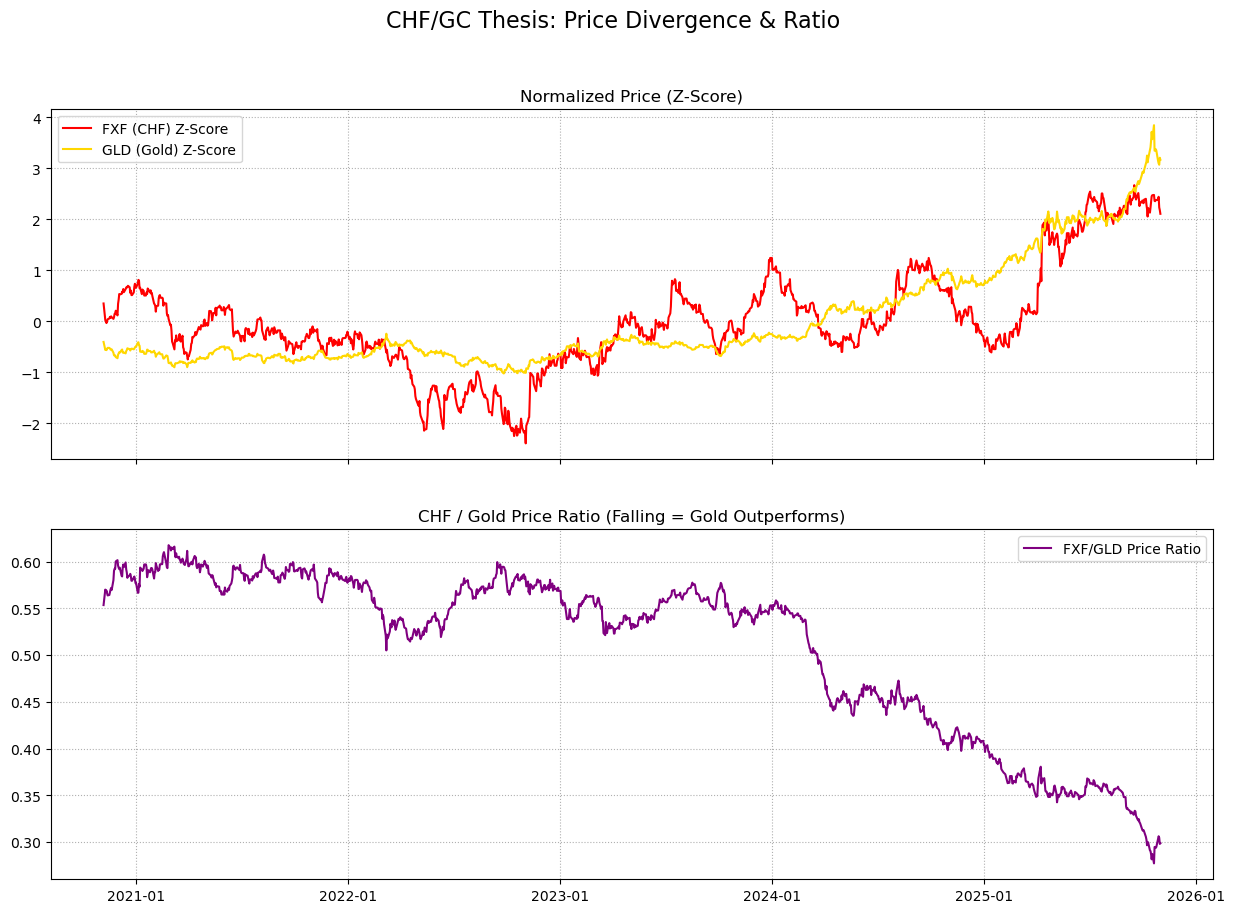

In [38]:
# Cell 9: Visualization - Core Thesis (Price vs. Ratio)
#
# Plot 1: Normalized prices of FXF vs. GLD.
# Plot 2: The FXF/GLD Ratio.
#
# This chart shows *what* is happening. When GLD outperforms FXF,
# the ratio in Plot 2 will fall.

try:
    print("Plotting Cell 9: Core Thesis...")
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    fig.suptitle('CHF/GC Thesis: Price Divergence & Ratio', fontsize=16)

    # Plot 1: Normalized Prices
    ax1.plot(df_normalized.index, df_normalized['FXF'], label='FXF (CHF) Z-Score', color='red')
    ax1.plot(df_normalized.index, df_normalized['GLD'], label='GLD (Gold) Z-Score', color='gold')
    ax1.set_title('Normalized Price (Z-Score)')
    ax1.legend()
    ax1.grid(True, linestyle=':')

    # Plot 2: Price Ratio
    ax2.plot(df.index, df['CHF_GLD_Ratio'], label='FXF/GLD Price Ratio', color='purple')
    ax2.set_title('CHF / Gold Price Ratio (Falling = Gold Outperforms)')
    ax2.legend()
    ax2.grid(True, linestyle=':')
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.show()

except Exception as e:
    print(f"❌ Cell 9: Plotting failed: {e}")

Plotting Cell 10: Causal Driver (Intervention)...


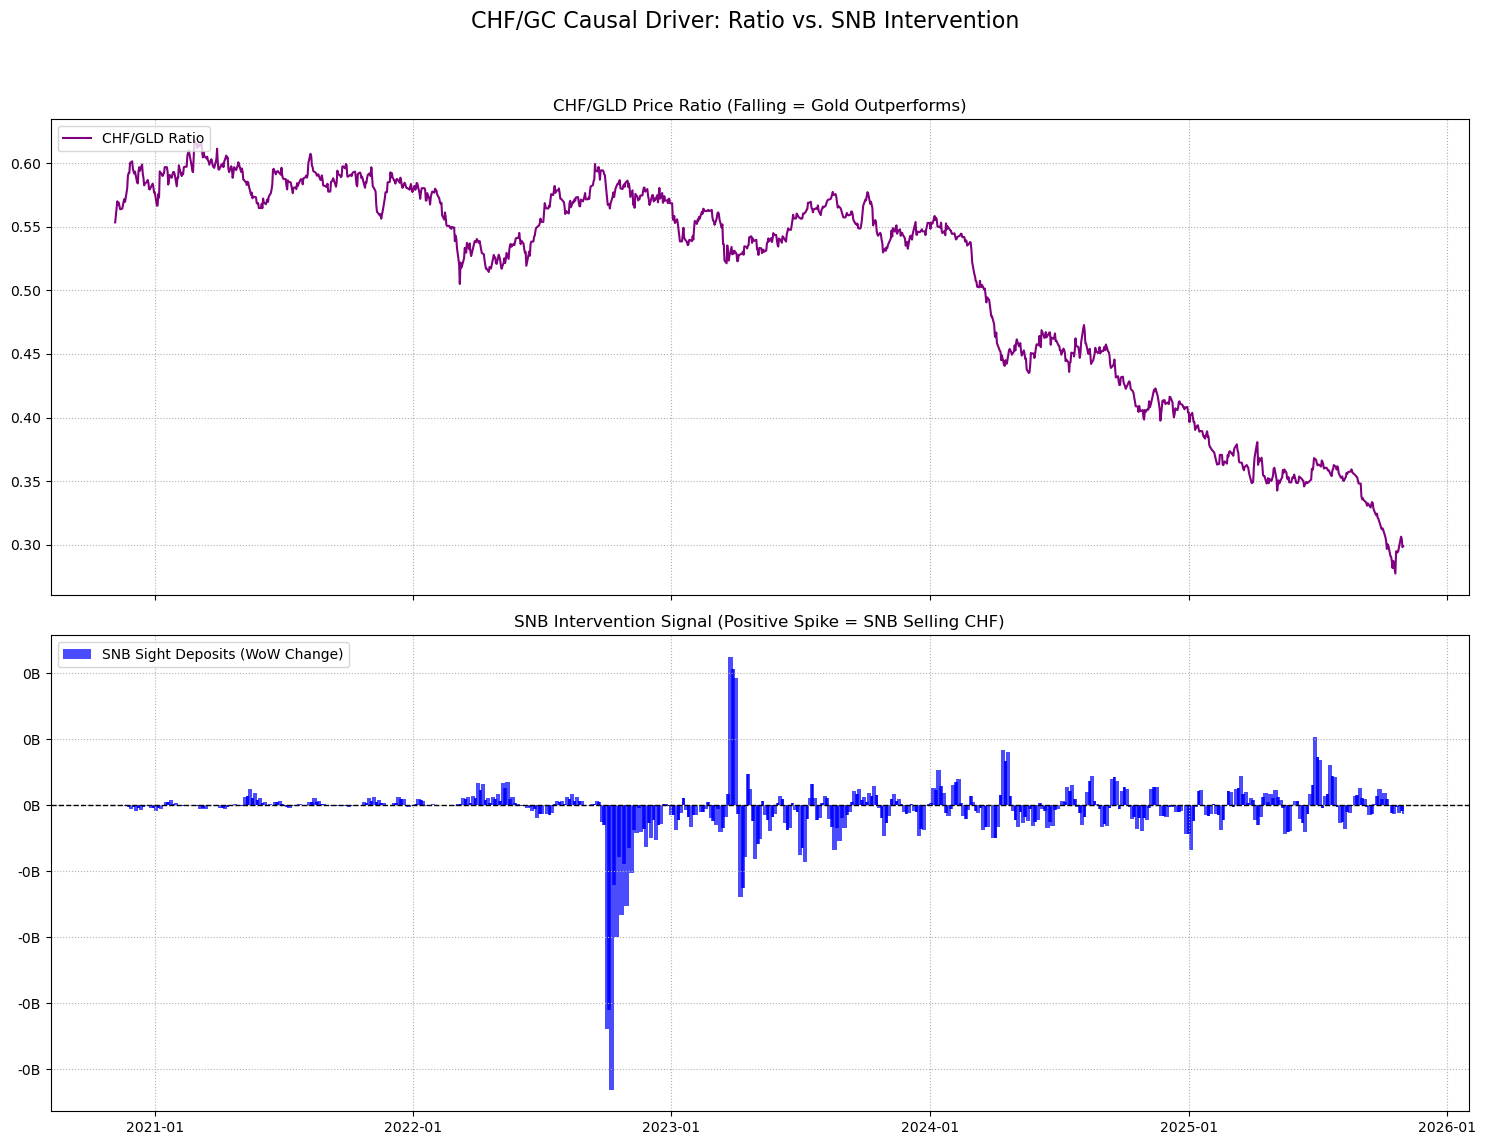

In [39]:
# Cell 10: Visualization - Causal Driver (SNB Intervention)
#
# Plot 1: The CHF/GLD Price Ratio.
# Plot 2: The SNB Intervention Signal (WoW change in Sight Deposits).
#
# This is the "arbitrage" chart.
# Thesis: A positive spike in Plot 2 (SNB selling CHF) should
# cause a *drop* in Plot 1 (CHF underperforms Gold).

try:
    print("Plotting Cell 10: Causal Driver (Intervention)...")
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True)
    fig.suptitle('CHF/GC Causal Driver: Ratio vs. SNB Intervention', fontsize=16)

    # --- Plot 1: The Price Ratio ---
    ax1.plot(df.index, df['CHF_GLD_Ratio'], label='CHF/GLD Ratio', color='purple')
    ax1.set_title('CHF/GLD Price Ratio (Falling = Gold Outperforms)')
    ax1.legend(loc='upper left')
    ax1.grid(True, linestyle=':')

    # --- Plot 2: The Intervention Signal ---
    # Use a bar chart to show the weekly *change*
    # --- Plot 2: The Intervention Signal ---
    ax2.bar(df.index, df['SNB_Intervention_WoW'],
            label='SNB Sight Deposits (WoW Change)',
            color='blue', alpha=0.7, width=3)
    ax2.axhline(0, color='black', linestyle='--', linewidth=1)
    ax2.set_title('SNB Intervention Signal (Positive Spike = SNB Selling CHF)')
    ax2.legend(loc='upper left')
    ax2.grid(True, linestyle=':')
    
    # Format Y-axis to be readable (in Billions)
    from matplotlib.ticker import FuncFormatter
    def billions_formatter(x, pos):
        return f'{x / 1e9:.0f}B'
    ax2.yaxis.set_major_formatter(FuncFormatter(billions_formatter))
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust for suptitle
    plt.show()

except Exception as e:
    print(f"❌ Cell 10: Plotting failed: {e}")

Plotting Cell 11: Correlation Breakdown...


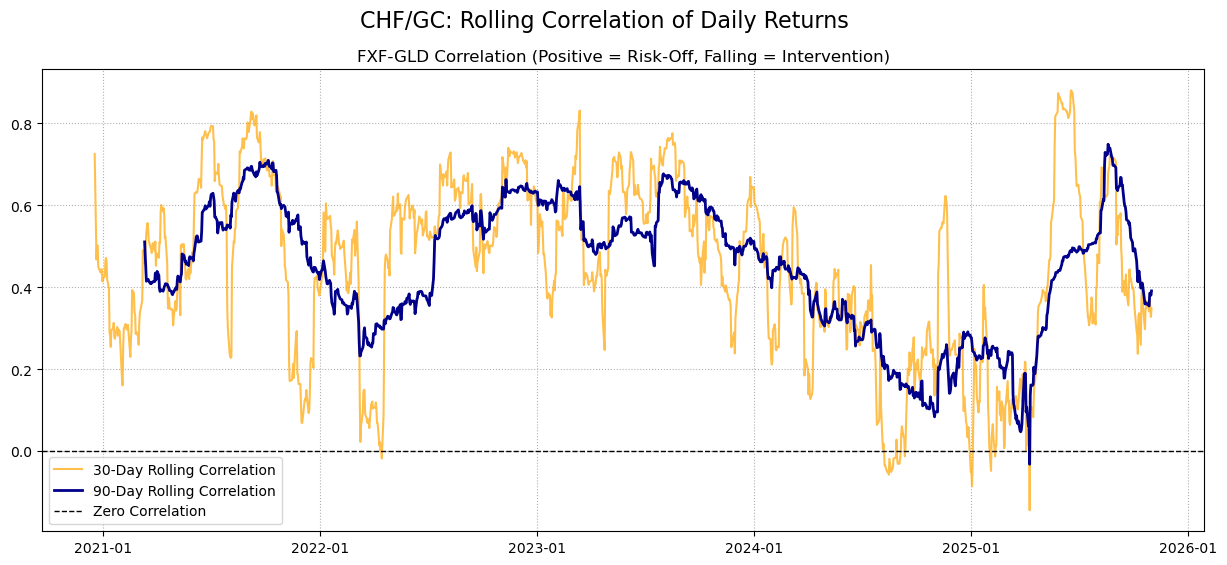

In [40]:
# Cell 11: Visualization - Correlation Breakdown
#
# Plot the 30-day and 90-day rolling correlation of returns.
#
# This chart quantifies the regime.
# * Positive = Classic "Global Risk-Off" (havens move together).
# * Falling/Negative = "SNB Intervention" (havens diverge).

try:
    print("Plotting Cell 11: Correlation Breakdown...")
    fig, ax1 = plt.subplots(figsize=(15, 6))
    fig.suptitle('CHF/GC: Rolling Correlation of Daily Returns', fontsize=16)

    ax1.plot(df.index, df['Corr_30D'], label='30-Day Rolling Correlation', color='orange', alpha=0.7)
    ax1.plot(df.index, df['Corr_90D'], label='90-Day Rolling Correlation', color='darkblue', linewidth=2)
    ax1.axhline(0, color='black', linestyle='--', linewidth=1, label='Zero Correlation')
    ax1.set_title('FXF-GLD Correlation (Positive = Risk-Off, Falling = Intervention)')
    ax1.legend()
    ax1.grid(True, linestyle=':')
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.show()

except Exception as e:
    print(f"❌ Cell 11: Plotting failed: {e}")

In [41]:
# Cell 12: LLM Analysis & Insights
#
# Pass the most recent data to the LLM for a qualitative synthesis.

try:
    print("Sending data to LLM for analysis...")
    
    # Get the latest data row
    latest_data = df.iloc[-1]
    
    # Get the most recent intervention signal (may be a few days old)
    latest_intervention = df['SNB_Intervention_WoW'].dropna().iloc[-1]
    latest_intervention_date = df['SNB_Intervention_WoW'].dropna().index[-1].strftime('%Y-%m-%d')
    
    # Create a summary of the latest data points
    data_summary = f"""
    - **Date:** {latest_data.name.strftime('%Y-%m-%d')}
    - **CHF/GLD Price Ratio:** {latest_data['CHF_GLD_Ratio']:.3f}
    - **FXF vs. GLD (Z-Score):** FXF at {df_normalized.iloc[-1]['FXF']:.2f}, GLD at {df_normalized.iloc[-1]['GLD']:.2f}
    - **90-Day Correlation:** {latest_data['Corr_90D']:.3f}
    - **10Y Real Yield (DFII10):** {latest_data['DFII10']:.2f}%
    - **SNB Intervention (WoW Change):** {latest_intervention / 1e9:.2f} Billion
    - **SNB Data Date:** {latest_intervention_date}
    """
    
    # Create the prompt
    prompt = f"""
    **Role:** You are an Independent Intelligence Desk Analyst, as per my thesis.
    
    **Thesis:** I am analyzing the CHF (FXF) vs. Gold (GLD) relationship.
    * **Regime 1 (Correlated):** "Global Risk-Off." Correlation is positive. A crisis drives *both* havens up.
    * **Regime 2 (Decorrelated):** "SNB Intervention." Correlation is falling/negative. A crisis drives GLD up, but the SNB *sells CHF* to cap its rise.
    
    **Key Signal:** The 'SNB Intervention' value. A large positive number (e.g., > 5B) means the SNB is actively selling CHF.
    
    **Latest OSINT Data:**
    {data_summary}
    
    **Your Task (Provide 3-bullet synthesis):**
    1.  **Regime Check:** Based on the `90-Day Correlation`, are we in a "Global Risk-Off" (correlated) regime or an "Intervention" (decorrelated) regime?
    2.  **Causal Driver:** Is the `SNB Intervention` signal active (e.g., a large positive or negative number)? How does this explain the recent move in the `CHF_GLD_Ratio`?
    3.  **Arbitrage/Trade Idea:** Based *only* on this data, what is the clear thematic trade? (e.g., "The data shows a strong SNB intervention signal, favoring Long GLD / Short FXF," or "The data shows no intervention, favoring a correlated Long FXF / Long GLD" basket.)
    """
    
    # Get LLM response
    llm_response = ask_llm(prompt)
    
    print("\n--- 🤖 LLM INTELLIGENCE SYNTHESIS ---")
    print(llm_response)
    print("-------------------------------------")

except Exception as e:
    print(f"❌ Cell 12: LLM Analysis failed: {e}")

Sending data to LLM for analysis...



--- 🤖 LLM INTELLIGENCE SYNTHESIS ---
### 3-Bullet Synthesis

1. **Regime Check:** Based on the `90-Day Correlation` of 0.391, we are not in a strong "Global Risk-Off" (correlated) regime. The correlation is relatively low, suggesting that the relationship between CHF and GLD has become less positive or even slightly negative over the past 90 days.

2. **Causal Driver:** The `SNB Intervention` signal shows no active intervention with a zero change of -0.00 Billion. This indicates that there is currently no significant SNB activity in selling CHF to cap its rise, which would otherwise drive GLD down during a crisis.

3. **Arbitrage/Trade Idea:** Given the data, it appears more favorable to adopt a correlated trade approach, as indicated by the lower correlation between CHF and GLD. Therefore, based on this information alone, one might consider a "Long FXF / Long GLD" basket, reflecting the current decorrelated regime where both assets may move independently rather than together in a cri